# 5: Water suppression with HSVD

In this tutorial we will take a look at water suppression. Water is present in the body at concentrations thousands of times higher than any of the metabolites we are interested in, so any spectrum where the water signal is not suppressed is completely dominated by the water peak centred at 4.7ppm.

The standard way to suppress the water is to use the CHESS (chemical shift selective) technique. This preparation method uses a frequency selective excitation pulse to excite only the spins in the region of the water peak, followed by a "crusher" gradient pulse which dephases the excited spins. Once they have lost their phase coherence, these spins will no longer contribute any signal during the acquisition. In practice, the basic CHESS technique has been superseded by first WET and now VAPOR, which use a sequence of CHESS style pulses with varying flip angles and delays to achieve greater tolerance to B1 variation, and generally improved performance.

However, in many cases, this prospective water suppression is insufficient to completely remove the water signal. Regions with poor shim, such as tumour, may have a water peak which partially extends outside the suppression region, and patient movement can have the same effect. Furthermore, many users choose to reduce the effect of water suppression by allowing a small amount of T1 recovery between the CHESS and the acquisition sequence. This approach, often referred to as "weak" water suppression, gives a large residual water peak which is useful during processing, for calculating channel weights and correcting frequency shifts. This peak must then be removed in a further processing step.

The methods available for removing the residual water peak generally involve some form of bandpass filter which removes the signal from a particular region of the spectrum. For this tutorial we are going to focus on the most widely used technique, HSVD (Hankel Singular Value Decomposition).

As usual, we start by importing our dependencies:

In [1]:
import suspect
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

For this tutorial, we will be using the SVS_30.rda data included in the Suspect test data collection, so that we don't have to worry about channel combination or frequency correction here. However, we will repeat the apodisation step described in [Tutorial 1](tut1_intro.html).

In [2]:
data = suspect.io.load_rda("/home/jovyan/suspect/tests/test_data/siemens/SVS_30.rda")

import scipy.signal
window = scipy.signal.tukey(data.np * 2)[data.np:]
data = window * data

If we plot the raw spectrum we immediately see that the water peak completely dominates all the other peaks in the spectrum:

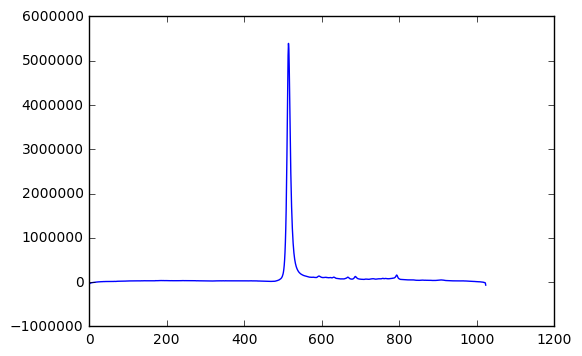

In [3]:
plt.plot(data.spectrum().real)

HSVD works by approximating the FID with a set of exponentially decaying components:

In [4]:
components = suspect.processing.water_suppression.hsvd(data, 20)

The second argument to the function is the number of components to generate. This will depend on both the number of peaks in the spectrum and how Lorentzian they are. Too few components will not be able to correctly describe the signal but too many can lead to over-fitting. Around 20 is typically a good number for most cases, but do experiment with your own data to understand better exactly what is going on.

The `hsvd()` function returns a `list` of `dict`s, with each `dict` containing information about one exponential component:

In [5]:
print(components[0])

{'phase': -2.3526332899894427, 'amplitude': 137.25589213068457, 'fwhm': 0.93358884978978407, 'frequency': 598.57586504857886}


This components `list` can be turned back into an FID using the `construct_fid()` function, which takes a list of components to be used and a reference time axis. In this example we also set the resulting FID to `inherit()` all the MRS properties from the original `data` object.

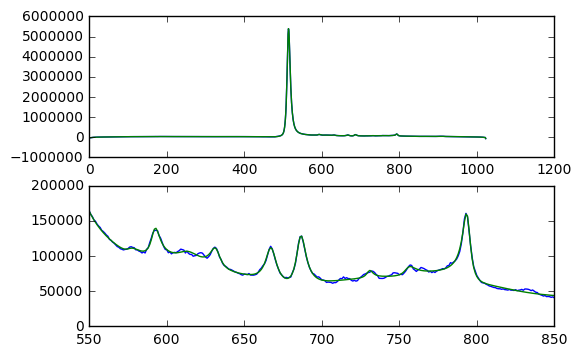

In [6]:
hsvd_fid = suspect.processing.water_suppression.construct_fid(components, data.time_axis())
hsvd_fid = data.inherit(hsvd_fid)
# plot two axes, one of the whole spectrum and one focussing on the metabolite region
f, (ax1, ax2) = plt.subplots(2)
ax2.set_xlim([550, 850])
ax2.set_ylim([0, 2e5])
for ax in (ax1, ax2):
    ax.plot(data.spectrum().real)
    ax.plot(hsvd_fid.spectrum().real)

Overall we see that the `hsvd_fid` is a very good approximation to the original `data` signal, although some of the smaller peaks such as the Glx region are not fitted. To get a better idea of what is going on, we can reconstruct each component individually and plot the whole set together.

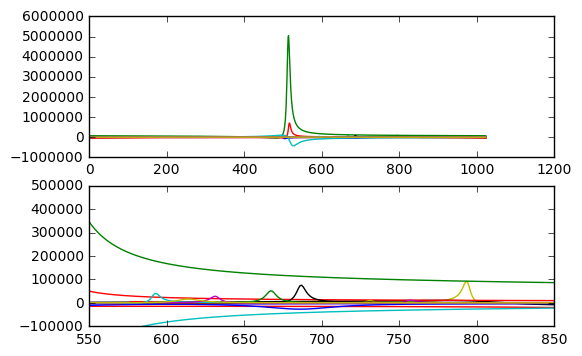

In [7]:
# plot two axes, one of the whole dataset and one of the metabolite region
f, (ax1, ax2) = plt.subplots(2)
ax2.set_xlim([550, 850])
ax2.set_ylim([-1e5, 5e5])
for component in components:
    component_fid = suspect.processing.water_suppression.construct_fid([component], data.time_axis())
    component_fid = data.inherit(component_fid)
    ax1.plot(component_fid.spectrum().real)
    ax2.plot(component_fid.spectrum().real)

What we find is that the major metabolite peaks each have one component associated with them, while the water peak has several. This is because it is not a perfect Lorentzian - to adequately describe the peak shape requires a series of progressively smaller correction terms to modify the main peak. Typically only the water peak gets multiple components as the others are too small, and the total number of components is limited.

The next step is to separate out the components making up the water signal from the metabolite components, which we do using a frequency cut-off. We can do this rather neatly using a Python list comprehension:

In [8]:
water_components = [component for component in components if component["frequency"] < 70 or component["fwhm"] > 100]

In this case we have selected all the components with frequencies below 80Hz. The best value for this cut-off frequency will depend strongly on your data, and of course on the field strength of the magnet, but 80Hz is a reasonable starting point for most people at 3T. For our data we don't have any peaks downfield of water so we don't need a negative frequency cut-off.

In addition we have selected a second set of components, this time with a FWHM greater than 100Hz. These very broad components are part of the baseline and it can be helpful to remove these at the same time.

Once we have selected the components we want to remove, we can simply subtract the constructed FIDs from our original data to arrive at the water suppressed spectrum.

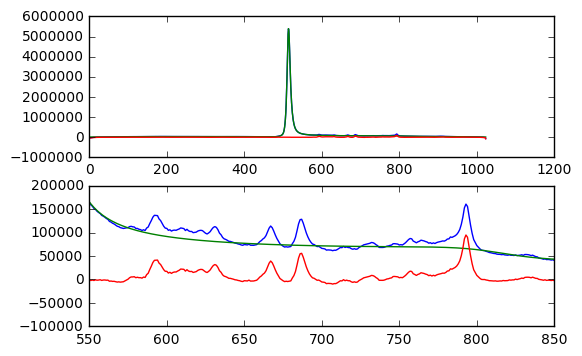

In [9]:
water_fid = suspect.processing.water_suppression.construct_fid(water_components, data.time_axis())
water_fid = data.inherit(water_fid)
dry_fid = data - water_fid
# plot two axes, one of the whole spectrum and one focussing on the metabolite region
f, (ax1, ax2) = plt.subplots(2)
ax2.set_xlim([550, 850])
ax2.set_ylim([-1e5, 2e5])
for ax in (ax1, ax2):
    ax.plot(data.spectrum().real)
    ax.plot(water_fid.spectrum().real)
    ax.plot(dry_fid.spectrum().real)

The `water_fid` accurately matches the residual water peak and the broad baseline, but does not include any of the metabolite peaks. Subtracting this from our data leaves a "dry" spectrum, without any remaining water contamination, ready for the next stage in the processing pipeline.